# Make compressed plots of female kinematics across age

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.plotting import format_plots, figure, save_factory, PlotConfig

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig3-kinematics", tight_layout=False)

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_syllable_df_v00.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18023989 entries, 0 to 18023988
Data columns (total 44 columns):
 #   Column          Dtype         
---  ------          -----         
 0   experiment      string        
 1   file            string        
 2   uuid            string        
 3   date            datetime64[us]
 4   age             int64         
 5   syllables       int16         
 6   pc_00           float32       
 7   pc_01           float32       
 8   pc_02           float32       
 9   pc_03           float32       
 10  pc_04           float32       
 11  pc_05           float32       
 12  pc_06           float32       
 13  pc_07           float32       
 14  pc_08           float32       
 15  pc_09           float32       
 16  true_depth      float32       
 17  session_name    string        
 18  subject_name    string        
 19  timestamps      float32       
 20  raw_timestamps  float32       
 21  area_mm         float32       
 22  area_px         

In [5]:
def compute_kinematics(df):
    mean_angular_speed = (df["angle"].diff(3) / 3).abs().mean() * 30
    mean_velocity = (
        df["velocity_2d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    mean_3d_velocity = (
        df["velocity_3d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    return pd.Series(dict(angular=mean_angular_speed, two_d=mean_velocity, three_d=mean_3d_velocity))

In [6]:
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)

In [11]:
kin_df = kin_df.query('angular > 0.1')

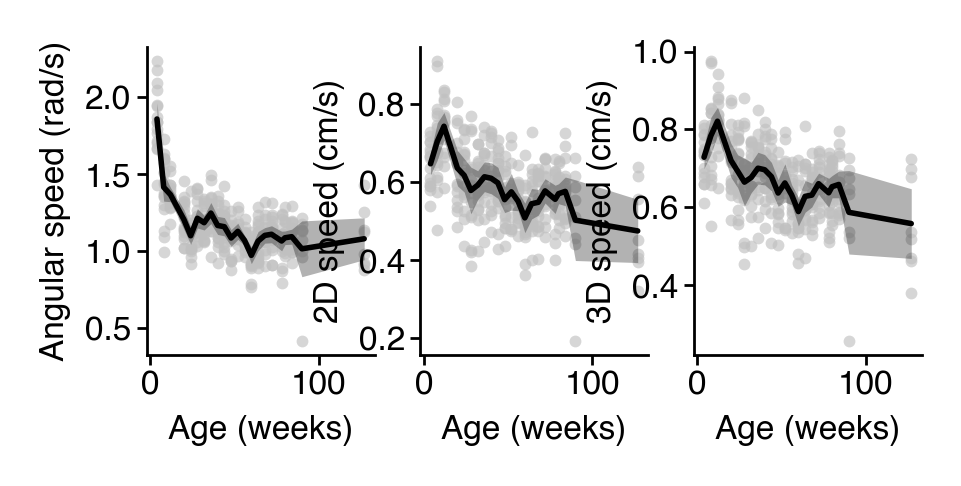

In [12]:
ylabel_map = dict(
    angular="Angular speed (rad/s)", two_d="2D speed (cm/s)", three_d="3D speed (cm/s)"
)

fig, ax = plt.subplots(1, 3, figsize=(2.5, 1), sharex=True)
for a, k in zip(ax.flat, ("angular", "two_d", "three_d")):
    a = sns.scatterplot(
        data=kin_df.reset_index(),
        x="age",
        y=k,
        linewidths=0,
        s=4.5,
        zorder=-1,
        color="silver",
        ax=a,
        alpha=0.65,
    )
    a = sns.lineplot(
        data=kin_df.reset_index(),
        x="age",
        y=k,
        errorbar=("se", 2),
        err_kws=dict(lw=0, alpha=0.3),
        color="k",
        ax=a,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (weeks)")
sns.despine()
saver(fig, "speeds-over-age");

In [13]:
size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100

In [15]:
size_df = size_df.query('area_mm > 1')

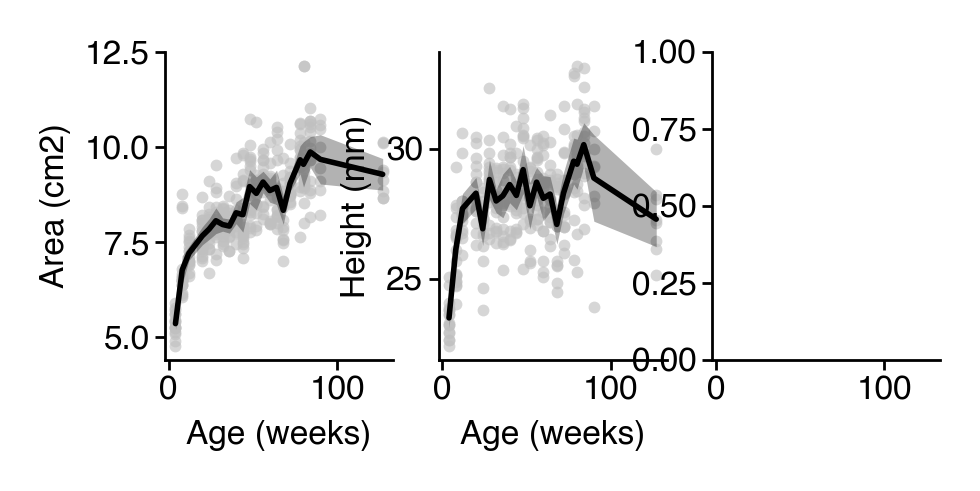

In [16]:
ylabel_map = dict(area_mm="Area (cm2)", height_ave_mm="Height (mm)")

fig, ax = plt.subplots(1, 3, figsize=(2.5, 1), sharex=True)
for a, k in zip(
    ax.flat,
    (
        "area_mm",
        "height_ave_mm",
    ),
):
    a = sns.scatterplot(
        data=size_df.reset_index(),
        x="age",
        y=k,
        linewidths=0,
        s=4.5,
        zorder=-1,
        color="silver",
        ax=a,
        alpha=0.65,
    )
    a = sns.lineplot(
        data=size_df.reset_index(),
        x="age",
        y=k,
        errorbar=("se", 2),
        err_kws=dict(lw=0, alpha=0.3),
        color="k",
        ax=a,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (weeks)")
sns.despine()
saver(fig, "sizes-over-age");